In [61]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, f1_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve
import imageio.v2 as imageio
import random

# Details of make_classification function
- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html



# 실습 1 : TPR과 FPR로 그려진 AUROC


In [62]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1000)

In [63]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=1000)

print('trainy - class0: ', len(trainy)-trainy.sum())
print('trainy - class1: ', trainy.sum())
print('----------------------')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())
print('============================')

# make testing dataset balance
undersample = RandomUnderSampler(sampling_strategy='majority')
testX, testy = undersample.fit_resample(testX, testy)

print('Balanced Testing date')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())

trainy - class0:  253
trainy - class1:  247
----------------------
testy - class0:  249
testy - class1:  251
Balanced Testing date
testy - class0:  249
testy - class1:  249


In [64]:
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


nth 0:positive: 249 negative: 249
---------------------------------------------
nth 1:positive: 225 negative: 249
---------------------------------------------
nth 2:positive: 200 negative: 249
---------------------------------------------
nth 3:positive: 175 negative: 249
---------------------------------------------
nth 4:positive: 150 negative: 249
---------------------------------------------
nth 5:positive: 125 negative: 249
---------------------------------------------
nth 6:positive: 100 negative: 249
---------------------------------------------
nth 7:positive: 75 negative: 249
---------------------------------------------
nth 8:positive: 50 negative: 249
---------------------------------------------
nth 9:positive: 25 negative: 249
---------------------------------------------


Text(0.5, 1.0, 'decreasing positive sample')

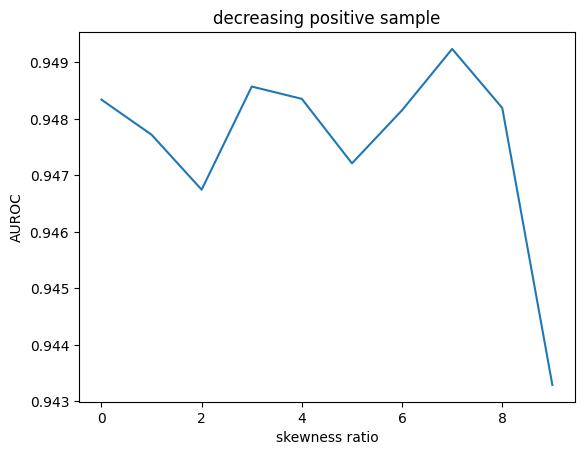

In [65]:
# repeat with different skewness
roc_list = []
lr_acc = []
k=1
for i in range(0, 10):
  pos_ind = np.where(testy==1)[0]
  n = int(i/10 * len(pos_ind))
  tmp_testX, tmp_testy = np.copy(testX), np.copy(testy)
  tmp_testX = np.delete(tmp_testX, pos_ind[:n], axis=0)
  tmp_testy = np.delete(tmp_testy, pos_ind[:n], axis=0)
  print('nth %d:positive: %d negative: %d'
        % (i, tmp_testy.sum(), tmp_testy.shape[0] - tmp_testy.sum()))
  print('---------------------------------------------')

  # predict probabilities
  lr_probs = model.predict_proba(tmp_testX)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # calculate scores
  lr_auc = roc_auc_score(tmp_testy, lr_probs)

  # summarize scores
  # print('iteration %d: Logistic: ROC AUC=%.3f' % (k, lr_auc))
  k += 1
  # calculate roc curves
  lr_fpr, lr_tpr, _ = roc_curve(tmp_testy, lr_probs)
  roc_list.append(lr_auc)

plt.plot(np.arange(0, len(roc_list)), roc_list)
plt.xlabel('skewness ratio')
plt.ylabel('AUROC')
plt.title('decreasing positive sample')


## 질문 1: 데이터 불균형이 심해지는데 AUROC 평가 지표는 왜 높게 형성이 될까요?

## 답변 1
보고서 링크: https://hyeonchan.notion.site/29fe91a35de980b3adf1dc5cf7d91669?pvs=73


**AUROC는 TPR과 FPR라는 지표를 사용하기 때문이다.**

1. **혼동 행렬 (Confusion Matrix)**

먼저 TPR과 FPR에 대해 알아보기 전에 혼동 행렬에 대해 알아보자.


TP: 실제 Positive를 Positive로 올바르게 예측

FN: 실제 Positive를 Negative로 틀리게 예측

FP: 실제 Negative를 Positive로 틀리게 예측

TN: 실제 Negative를 Negative로 올바르게 예측

1. **TPR (True Positive Rate)**

TPR이란 모델이 실제 Positive를 얼마나 올바르게 예측하는지 평가하는 지표이다. (=Recall)

**실제 Positive인 샘플 중에서 모델이 Positive라고 올바르게 예측한 비율**을 의미한다.

$TPR=\frac{TP}{TP+FN}$ 

1. **FPR (False Positive Rate)**

FPR이란 모델이 얼마나 잘못된 예측을 하는지 평가하는 지표이다.

**실제 Negative인 샘플 중에서 모델이 Positive라고 잘못 예측한 비율**을 의미한다.

$FPR=\frac{FP}{FP+TN}$

1. **임계값과 TPR/FPR의 관계**

위 내용을 종합해보면, TPR이 높고 FPR이 낮을수록 모델의 성능이 좋아진다.

모델의 Positive와 Negative를 결정하는 기준을 임계값(Threshold)이라 하는데, 이 값을 조절해보면 FPR과 TPR은 **트레이드 오프 관계**라는 걸 알 수 있다.

만약 임계값을 낮추면 (Positive의 비율을 높이면) 더 많은 실제 Positive를 잡아낼 수 있다 (TPR 증가). 

하지만 Negative를 Positive로 잘못 판단하는 경우도 늘어난다 (FPR 증가). 

결과적으로 True Positive와 False Positive가 동시에 증가한다.

반대로 임계값을 높이면 (Positive의 비율을 낮추면) Negative를 잘못 판단하는 실수가 줄어든다 (FPR 감소).

하지만 그만큼 실제 Positive도 놓치게 된다 (TPR 감소).

결과적으로 True Positive와 False Positive가 동시에 감소한다.

1. **ROC 곡선과 AUROC**

ROC 곡선은 모델의 임계값을 0부터 1까지 변경하면서, 모든 임계값 지점에서 계산되는 **FPR과 TPR의 관계**를 그린 그래프이다.


- X축 (FPR): 0~1 (잘못된 예측의 비율)
- Y축 (TPR): 0~1 (정확한 예측의 비율)

AUROC는 ROC 곡선 아래의 면적을 계산한 값으로, 0.5~1 사이의 값을 가진다.

AUROC는 임의로 선택된 Positive 샘플의 예측 확률이 Negative 샘플보다 높을 확률이다.

즉, **모델이 두 클래스를 얼마나 잘 분리하는지를 나타내는 지표**다.

1. **결론**

AUROC는 TPR과 FPR의 관계를 이용해 그린 ROC 곡선에서 얻어내는 지표이다.

그리고 이 두 지표는 각 클래스(Positive, Negative) **내부의 비율에 기반**하므로, 불균형에 상대적으로 덜 민감하다.

# 실습 2 : Precision, Recall, F1 Score의 이해


In [66]:
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1000)

In [67]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=1000)

print('trainy - class0: ', len(trainy)-trainy.sum())
print('trainy - class1: ', trainy.sum())
print('----------------------')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())
print('============================')

# make testing dataset balance
undersample = RandomUnderSampler(sampling_strategy='majority')
testX, testy = undersample.fit_resample(testX, testy)

print('Balanced Testing date')
print('testy - class0: ', len(testy)-testy.sum())
print('testy - class1: ', testy.sum())

trainy - class0:  253
trainy - class1:  247
----------------------
testy - class0:  249
testy - class1:  251
Balanced Testing date
testy - class0:  249
testy - class1:  249


In [68]:
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


nth 0:positive: 249 negative: 249
---------------------------------------------
nth 1:positive: 225 negative: 249
---------------------------------------------
nth 2:positive: 200 negative: 249
---------------------------------------------
nth 3:positive: 175 negative: 249
---------------------------------------------
nth 4:positive: 150 negative: 249
---------------------------------------------
nth 5:positive: 125 negative: 249
---------------------------------------------
nth 6:positive: 100 negative: 249
---------------------------------------------
nth 7:positive: 75 negative: 249
---------------------------------------------
nth 8:positive: 50 negative: 249
---------------------------------------------
nth 9:positive: 25 negative: 249
---------------------------------------------


Text(0.5, 1.0, 'decreasing positive sample')

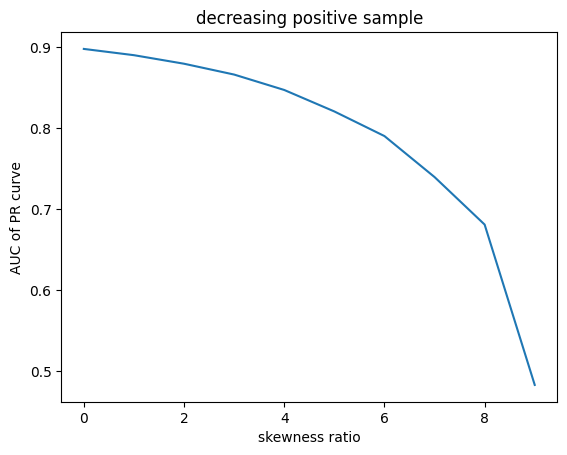

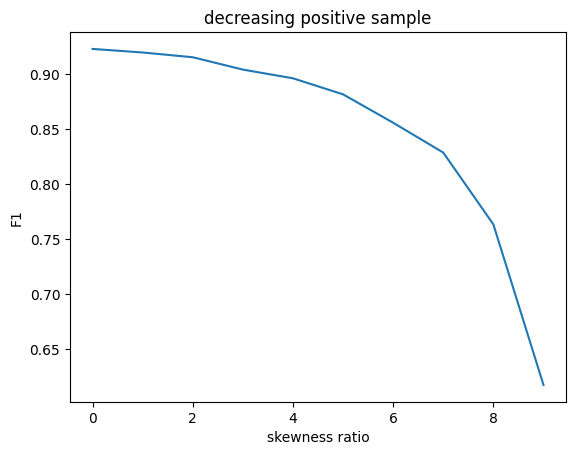

In [69]:
roc_list = []
f1_list = []

k=1
for i in range(0, 10):
  pos_ind = np.where(testy==1)[0]
  n = int(i/10 * len(pos_ind))
  tmp_testX, tmp_testy = np.copy(testX), np.copy(testy)
  tmp_testX = np.delete(tmp_testX, pos_ind[:n], axis=0)
  tmp_testy = np.delete(tmp_testy, pos_ind[:n], axis=0)
  print('nth %d:positive: %d negative: %d'
        % (i, tmp_testy.sum(), tmp_testy.shape[0] - tmp_testy.sum()))
  print('---------------------------------------------')


  # predict probabilities
  lr_probs = model.predict_proba(tmp_testX)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # predict class values
  yhat = model.predict(tmp_testX)
  # calculate precision and recall for each threshold
  lr_precision, lr_recall, _ = precision_recall_curve(tmp_testy, lr_probs)
  # calculate scores
  lr_f1, lr_auc = f1_score(tmp_testy, yhat), auc(lr_recall, lr_precision)
  # summarize scores
  # print('iteration%d Logistic: f1=%.3f auc=%.3f' % (k, lr_f1, lr_auc))
  k += 1
  roc_list.append(lr_auc)
  f1_list.append(lr_f1)

plt.plot(np.arange(0, len(roc_list)), roc_list)
plt.xlabel('skewness ratio')
plt.ylabel('AUC of PR curve')
plt.title('decreasing positive sample')

plt.figure()
plt.plot(np.arange(0, len(roc_list)), f1_list)
plt.xlabel('skewness ratio')
plt.ylabel('F1')
plt.title('decreasing positive sample')


## 질문 2: AUC, RC Curve와 F1 Curve는 데이터 불균형에 강건한 평가지표인가요? 강건하다면 AUROC보다  강건한 이유를, 그렇지 않다면 강건하지 않은 이유를 설명해주세요.

## 답변 2
1. **PR Curve (Precision-Recall Curve)**

Precision-Recall Curve는 **Precision과 Recall의 관계를 시각화한 곡선**이다.

- Precision: 모델이 예측한 샘플 중 실제 Positive의 비율 (모델의 예측이 얼마나 정확한지)
    
    $Precision=\frac{TP}{TP+FP}$ 
    
- Recall: 모델이 Positive로 올바르게 예측한 비율 (실제 Positive를 얼마나 놓치지 않았는지)
    
    $Recall=\frac{TP}{FN+TP}$
    

PR Curve는 임계값을 0~1까지 변경해가며 X축에 Recall, Y축에 Precision을 표시한 그래프이다.

1. **F1 Curve**

F1 Curve는 **Precision과 Recall의 조화평균으로 나타낸 곡선**이다.

$F1= 2 \times \frac{Precision\times Recall}{Precision+Recall}$

그렇기에 Precision과 Recall의 지표가 모두 높을 때 1에 가깝게 나온다.

Precision이나 Recall 중 하나라도 낮으면, F1 Score는 크게 감소한다.

따라서 F1 Curve는 모델의 임계값에 따라 Precision과 Recall이 어떻게 균형을 이루는지를 보여주는 지표이다.

1. **PR Curve와 F1 Curve의 데이터 불균형에 대한 강건성**

강건하다의 의미를 두 가지로 나누어 살펴볼 필요가 있다.

1. **불균형에 영향을 덜 받음**
    - 오히려 AUROC가 불균형에 영향을 덜 받는 지표이다. AUROC는 TPR과 FPR을 사용하며, 두 지표 모두 클래스 내부 비율을 기준으로 계산된다. 따라서 클래스 비율이 변하더라도 큰 왜곡이 발생하지 않는다.
    - 반면 PR Curve와 F1 Score는 Precision을 사용한다. Precision의 분모는 TP + FP이기에 Negative 클래스의 개수에 직접적 영향을 받는다. 즉 **Negative가 많아질수록 FP가 상대적으로 늘어나 데이터 불균형에 민감**하다.
2. **불균형 데이터를 잘 반영함**
    - AUROC는 FPR의 분모에 TN이 포함되어 있어, Negative가 압도적으로 많을 경우 FP가 늘어나도 FPR이 미세하게만 증가한다. 따라서 **불균형 상황에서는 AUROC 값이 좋게 보이는 착시가 발생**한다. 즉, 모델이 실제 Positive를 거의 찾지 못해도 AUROC는 높게 유지될 수 있다.
    - PR Curve와 F1-Score는 Positive 클래스의 탐지 성능에 집중한다. Precision과 Recall 모두 TN(실제 Negative)과 무관하게, Positive 관련 예측만 고려한다. 따라서 불균형 상황에서도 모델이 실제 Positive를 얼마나 잘 찾고 있는지를 정확하게 반영한다.

결론적으로, **AUROC는 불균형 비율 변화에 안정적**이지만 Positive 탐지 성능을 과대평가할 수 있다.

**PR Curve / F1-Score는 불균형에는 민감**하지만, Positive 중심 평가로 불균형 상황에 더 적합하다.

##

# 실습 3 : Convex Function

In [70]:
x = np.arange(-2, 2, 0.01)

# 세 개의 함수 중 하나를 선택해서 돌려보세요
# f = lambda x: 0.5 * x ** 2
# f = lambda x: np.cos(np.pi * x)
f = lambda x: -0.5 * x ** 4

filenames=[]
for lamda in np.arange(0, 1, 0.02):
  # LHS
  tmp_x = lamda*x[0] + (1-lamda)*x[-1]

  # RHS
  x_line, y_line = np.array([x[0], x[-1]]), np.array([lamda*f(x[0]), (1-lamda)*f(x[-1])])

  # compute LHS and RHS
  LHS = f(tmp_x)
  RHS = lamda*f(x[0]) + (1-lamda)*f(x[-1])
  if LHS > RHS:
    print('At lamda %0.3f, it is concave' % lamda)
    print('lhs %.5f rhs %.5f' % (LHS, RHS))

  plt.figure()
  # original graph
  plt.plot(x, f(x), label='f(x)')
  # plot RHS
  plt.plot(x_line, y_line, label='%0.3f' % lamda)
  # plot LHS
  plt.scatter(tmp_x, f(tmp_x))
  #title, legennd
  plt.title('lhs %.3f rhs %.3f' % (LHS, RHS))
  plt.legend()
  plt.savefig('lamda %0.3f.png' % lamda)
  plt.close()
  filenames.append('lamda %0.3f.png' % lamda)

# Build GIF
with imageio.get_writer('mygif2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

At lamda 0.020, it is concave
lhs -6.65710 rhs -7.84437
At lamda 0.040, it is concave
lhs -5.61247 rhs -7.84755
At lamda 0.060, it is concave
lhs -4.69589 rhs -7.85072
At lamda 0.080, it is concave
lhs -3.89644 rhs -7.85390
At lamda 0.100, it is concave
lhs -3.20369 rhs -7.85708
At lamda 0.120, it is concave
lhs -2.60770 rhs -7.86025
At lamda 0.140, it is concave
lhs -2.09901 rhs -7.86343
At lamda 0.160, it is concave
lhs -1.66864 rhs -7.86660
At lamda 0.180, it is concave
lhs -1.30811 rhs -7.86978
At lamda 0.200, it is concave
lhs -1.00943 rhs -7.87296
At lamda 0.220, it is concave
lhs -0.76507 rhs -7.87613
At lamda 0.240, it is concave
lhs -0.56802 rhs -7.87931
At lamda 0.260, it is concave
lhs -0.41173 rhs -7.88249
At lamda 0.280, it is concave
lhs -0.29015 rhs -7.88566
At lamda 0.300, it is concave
lhs -0.19773 rhs -7.88884
At lamda 0.320, it is concave
lhs -0.12936 rhs -7.89201
At lamda 0.340, it is concave
lhs -0.08048 rhs -7.89519
At lamda 0.360, it is concave
lhs -0.04696 rhs -

## 질문 3-1: 3개의 함수를 확인할 수 있습니다. 3개의 함수중 최적화가 쉬운 함수는 무엇이고, 왜 그 함수가 최적화하기 쉬울까요?

## 답변 3-1:
1. **코드 실행**

```python
f = lambda x: 0.5 * x ** 2          # 1) Convex
# f = lambda x: np.cos(np.pi * x)   # 2) 다중 최적해
# f = lambda x: -0.5 * x ** 4       # 3) Concave
```

1. **두 번째 함수**

두 번째 함수는 **여러 개의 지역 최적해**가 존재한다.

여러 개의 지역 최적해가 존재한다는 것은 기울기가 0이 되는 지점이 여러 개 존재한다는 것이다.

한 번 특정 지역 최적점에 도달하면 더 낮은 전역 최적점으로 이동할 수 없다.

**즉, 전역 최적해로의 수렴이 보장되지 않으며 초기값에 따라 완전히 다른 해에 수렴**할 수 있다.


1. **세 번째 함수**

세 번째 함수는 Concave 함수이다.

최적화는 일반적으로 **함수의 최소값을 찾는 문제**로 정의되며, 값을 작게 만드는 방향으로 이동한다.

그러나 오목 함수는 최대값을 갖는 형태이므로, 기울기를 따라 내려가면 전역 최댓값이 아니라 **경계로 향하거나 발산**하게 된다.


1. **첫 번째 함수**

첫 번째 함수는 **Convex 함수**이다.

**기울기가 0이 되는 지점이 단 하나만 존재**하기에 **지역 최적해와 전역 최적해가 항상 일치**한다.

어떤 초기값에서도 안정적으로 전역 최적해에 도달할 수 있다


## 질문 3-2: 지역 최적해(local minimum)'와 '전역 최적해(global minimum)'의 차이점과 연관 지어, Non-convex 함수를 최적화할 때 발생할 수 있는 문제점은 무엇인지 설명해주세요.

## 답변 3-2:
1. 지역 최적해와 전역 최적해
- 지역 최적해: 함수의 특정 구간에서만 가장 작은 값을 갖는 지점
- 전역 최적해: 함수 전체 영역에서 가장 작은 값을 갖는 지점

즉 **지역 최적해는 부분적으로 낮은 지점이고 전역 최적해는 전체에서 가장 낮은 지점**이다.


2. Non-convex 함수의 특성

Non-convex 함수는 곡선이 여러 번 굴곡지기에 **여러 개의 지역 최적해**를 가진다.

즉 **기울기가 0이 되는 지점이 여러 개 존재**한다.


3. Non-convex 함수의 최적화 시 문제점

1. **지역 최적해에 수렴**
    - 여러 개의 지역 최적해가 존재하면 전역 최소점이 아닌 지역 최소점에 머물기에 전역 해에 도달하지 못할 수 있다.
2. **초기값에 따른 민감도**
    - 시작점에 따라 다른 지역 최소로 이동하기에 초기값에 따라 결과가 달라진다.
3. **전역 최적해 보장 불가**
    - Convex 함수는 지역 최적해가 곧 전역 최적해이지만 Non-convex 함수에서는 그렇지 않다.

# 실습 4 : SGD Optimization

In [71]:
# Define batch_size before using it in make_batch function
batch_size = 32


In [72]:
def make_data():
    x1 = random.randint(0, 1)
    x2 = random.randint(0, 1)
    yy = 0 if (x1 == x2) else 1

    # centered at zero
    x1 = 2. * (x1 - 0.5)
    x2 = 2. * (x2 - 0.5)
    yy = 2. * (yy - 0.5)

    # add noise
    x1 += 0.1 * random.random()
    x2 += 0.1 * random.random()
    yy += 0.1 * random.random()

    return [x1, x2, ], yy

def make_batch():
    data = [make_data() for ii in range(batch_size)]
    labels = [label for xx, label in data]
    data = [xx for xx, label in data]
    return np.array(data, dtype='float32'), np.array(labels, dtype='float32')

In [73]:
train_data = [make_batch() for ii in range(500)]
test_data = [make_batch() for ii in range(50)]

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [75]:
torch.manual_seed(42)

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.dense1 = nn.Linear(2, 2)
        self.dense2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.tanh(self.dense1(x))
        x = self.dense2(x)
        return torch.squeeze(x)

In [76]:
# initialize our network
model = NN()

## optimizer = stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr = 0.1)


## train and test functions
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_data):
        data, target = Variable(torch.from_numpy(data)), Variable(torch.from_numpy(target))
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} {}\tLoss: {:.4f}'.format(epoch, batch_idx * len(data), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_data:
        data, target = Variable(torch.from_numpy(data), volatile=True), Variable(torch.from_numpy(target))
        output = model(data)
        test_loss += F.mse_loss(output, target)
        correct += (np.around(output.data.numpy()) == np.around(target.data.numpy())).sum()

    test_loss /= len(test_data)
    test_loss = test_loss.item()

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, batch_size * len(test_data), 100. * correct / (batch_size * len(test_data))) )

In [77]:
## run experiment
nepochs = 100
lr = 0.1

print('lr=', lr)
for epoch in range(1, nepochs + 1):
    train(epoch)
    print('---------------------------------------------')
    test()

lr= 0.1
Train Epoch: 1 0	Loss: 1.2287
Train Epoch: 1 3200	Loss: 0.0448
Train Epoch: 1 6400	Loss: 0.0011
Train Epoch: 1 9600	Loss: 0.0012
Train Epoch: 1 12800	Loss: 0.0012
---------------------------------------------

Test set: Average loss: 0.0011, Accuracy: 1600/1600 (100.00%)

Train Epoch: 2 0	Loss: 0.0006
Train Epoch: 2 3200	Loss: 0.0011
Train Epoch: 2 6400	Loss: 0.0011
Train Epoch: 2 9600	Loss: 0.0012


C:\Users\hye0nchan\AppData\Local\Temp\ipykernel_23208\3879544526.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(torch.from_numpy(data), volatile=True), Variable(torch.from_numpy(target))


Train Epoch: 2 12800	Loss: 0.0012
---------------------------------------------

Test set: Average loss: 0.0010, Accuracy: 1600/1600 (100.00%)

Train Epoch: 3 0	Loss: 0.0006
Train Epoch: 3 3200	Loss: 0.0011
Train Epoch: 3 6400	Loss: 0.0011
Train Epoch: 3 9600	Loss: 0.0012
Train Epoch: 3 12800	Loss: 0.0012
---------------------------------------------

Test set: Average loss: 0.0010, Accuracy: 1600/1600 (100.00%)

Train Epoch: 4 0	Loss: 0.0006
Train Epoch: 4 3200	Loss: 0.0010
Train Epoch: 4 6400	Loss: 0.0011
Train Epoch: 4 9600	Loss: 0.0011
Train Epoch: 4 12800	Loss: 0.0011
---------------------------------------------

Test set: Average loss: 0.0010, Accuracy: 1600/1600 (100.00%)

Train Epoch: 5 0	Loss: 0.0006
Train Epoch: 5 3200	Loss: 0.0010
Train Epoch: 5 6400	Loss: 0.0011
Train Epoch: 5 9600	Loss: 0.0011
Train Epoch: 5 12800	Loss: 0.0011
---------------------------------------------

Test set: Average loss: 0.0010, Accuracy: 1600/1600 (100.00%)

Train Epoch: 6 0	Loss: 0.0006
Train E

## 실습 4: lr값을 다음 4개의 값으로 돌려보고, 어떤 value가 왜 적절한지 설명해주세요. lr값을 다음 4개의 값으로 돌려보고, 어떤 value가 왜 적절한지 설명해주세요. lr = [0,0001, 0.001, 0.01, 0.1]

## 답변 4  
1. 학습률 (Learning Rate)

학습률은 경사하강법에서 가중치를 업데이트할 때 **이동하는 크기 (Step size)를 결정하는 하이퍼파라미터**이다. 너무 작으면 수렴이 늦어지고 너무 크면 발산하거나 진동할 수 있다.

2. 실험 결과 및 분석

1. LR = 0.0001
    - 관찰: **손실이 천천히 감소**하며 일정 수준 이하로 잘 내려가지 않음
    - 추정: step이 너무 작아 평탄 구간 / 지역해 근처에서 머뭄
    
    ```
    Train Epoch: 1 0	Loss: 1.4701
    Train Epoch: 1 3200	Loss: 1.2156
    Train Epoch: 1 6400	Loss: 1.4234
    Train Epoch: 1 9600	Loss: 1.2143
    Train Epoch: 1 12800	Loss: 1.2964
    
    ...
    
    Train Epoch: 4 0	Loss: 1.2505
    Train Epoch: 4 3200	Loss: 1.0541
    Train Epoch: 4 6400	Loss: 1.2116
    Train Epoch: 4 9600	Loss: 1.0897
    Train Epoch: 4 12800	Loss: 1.1411
    ```
    
2. LR = 0.001
    - 관찰: 0.0001 대비 개선되지만 여전히 완만한 하강, 낮은 구간으로의 진입이 더딤
    - 추정: 여전히 step이 너무 작아 평탄 구간 / 지역해 근처에서 머뭄
    
    ```
    Train Epoch: 1 0	Loss: 1.0741
    Train Epoch: 1 3200	Loss: 1.1589
    Train Epoch: 1 6400	Loss: 0.9062
    Train Epoch: 1 9600	Loss: 1.1113
    Train Epoch: 1 12800	Loss: 1.0750
    
    ...
    
    Train Epoch: 4 0	Loss: 0.9590
    Train Epoch: 4 3200	Loss: 1.0053
    Train Epoch: 4 6400	Loss: 0.9372
    Train Epoch: 4 9600	Loss: 0.9744
    ```
    
3. LR = 0.01
    - 관찰: 초기부터 **손실값이 빠르고 안정적으로 감소**
    - 추정: 속도와 안정성의 균형이 좋은 것으로 보아 적절해보임
    
    ```
    Train Epoch: 1 0	Loss: 1.3017
    Train Epoch: 1 3200	Loss: 1.0067
    Train Epoch: 1 6400	Loss: 0.9424
    Train Epoch: 1 9600	Loss: 0.8358
    Train Epoch: 1 12800	Loss: 0.6348
    
    ...
    
    Train Epoch: 4 0	Loss: 0.0008
    Train Epoch: 4 3200	Loss: 0.0008
    Train Epoch: 4 6400	Loss: 0.0008
    Train Epoch: 4 9600	Loss: 0.0013
    Train Epoch: 4 12800	Loss: 0.0014
    ```
    
4. LR = 0.1
    - 관찰: 손실값이 매우 가파르게 감소, 수렴하긴 했는데 **미세한 진동**이 있는 것 같아서 불안함
    - 추정: 모델의 크기가 커지면 불안정성이 확대될 거 같음
    
    ```
    Train Epoch: 1 0	Loss: 0.9642
    Train Epoch: 1 3200	Loss: 0.0020
    Train Epoch: 1 6400	Loss: 0.0008
    Train Epoch: 1 9600	Loss: 0.0013
    Train Epoch: 1 12800	Loss: 0.0013
    
    ... 
    
    Train Epoch: 4 0	Loss: 0.0006
    Train Epoch: 4 3200	Loss: 0.0009
    Train Epoch: 4 6400	Loss: 0.0008
    Train Epoch: 4 9600	Loss: 0.0012
    Train Epoch: 4 12800	Loss: 0.0013
    ```
    

1. **비교**

| IR | 초기 하강 속도 | 최종 손실 | 평가 |
| --- | --- | --- | --- |
| 0.0001 | 느림 | > 1.0  | 비효율 |
| 0.001 | 보통 | ~1.0 전후  | 비효율 |
| 0.01 | 빠름 | ~1e-3 | 적절 |
| 0.1 | 매우 빠름 | ~1e-3 | 적절 |

# 실습 5: Sigmoid Function

In [78]:
f = lambda x, w, b: 1/(1 + np.exp(-(w*x + b)))

x = np.arange(-10, 10, 0.01).reshape([-1, 1])

# effect of weight on sigmoid function
filenames = []
for i in np.arange(1, 5, 0.1):
  w = np.ones([1, 1]) * i * 0.5
  b = np.ones([1, 1]) * 0

  plt.plot(x, f(x, w, b))
  plt.title('w = %0.1f' % i)
  plt.grid()
  plt.savefig('w %0.1f.png' % i)
  plt.close()
  filenames.append('w %0.1f.png' % i)

# Build GIF
with imageio.get_writer('w_mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


In [79]:
f = lambda x, w, b: 1/(1 + np.exp(-(w*x + b)))

x = np.arange(-10, 10, 0.01).reshape([-1, 1])

# effect of bias on sigmoid function
filenames = []
for i in np.arange(1, 5, 0.1):
  w = np.ones([1, 1])
  b = np.ones([1, 1])* i

  plt.plot(x, f(x, w, b))
  plt.title('b = %0.1f' % i)
  plt.grid()
  plt.savefig('b %0.1f.png' % i)
  plt.close()
  filenames.append('b %0.1f.png' % i)

# Build GIF
with imageio.get_writer('b_mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# 실습 6: Logistic Regression

In [80]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [81]:
input_size = 28 * 28  # 784
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [82]:
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../data
    Split: Train
    StandardTransform
Transform: ToTensor()
----------------
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../../data
    Split: Test
    StandardTransform
Transform: ToTensor()

training data shape:  torch.Size([60000, 28, 28])


c:\Users\hye0nchan\miniconda3\envs\ml_2025\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Text(0.5, 1.0, 'n = 107 label = 3')

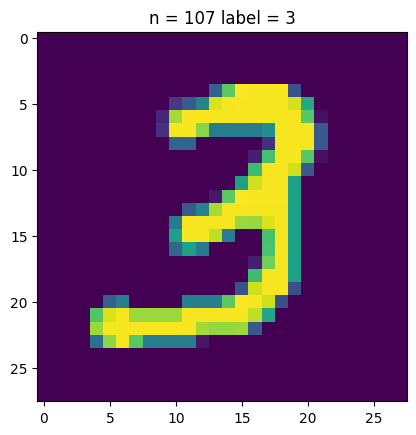

In [83]:
# 2.3.1 Check data
print(train_dataset)
print('----------------')
print(test_dataset)
print()

import matplotlib.pyplot as plt
print('training data shape: ', train_dataset.data.shape)
n = np.random.randint(0, 60000)
plt.imshow(train_dataset.data[n])
plt.title(f'n = %d label = %d' % (n, train_dataset.train_labels[n].numpy()))

In [84]:
#2.4 Logistic regression model
model = nn.Linear(input_size, num_classes)

#2.5 Cross Entropy Loss
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()

#2.6 Optimizer Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#2.7 Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/600], Loss: 2.2012
Epoch [1/5], Step [200/600], Loss: 2.1062
Epoch [1/5], Step [300/600], Loss: 2.0059
Epoch [1/5], Step [400/600], Loss: 1.9329
Epoch [1/5], Step [500/600], Loss: 1.8637
Epoch [1/5], Step [600/600], Loss: 1.7757
Epoch [2/5], Step [100/600], Loss: 1.7562
Epoch [2/5], Step [200/600], Loss: 1.6472
Epoch [2/5], Step [300/600], Loss: 1.6535
Epoch [2/5], Step [400/600], Loss: 1.5377
Epoch [2/5], Step [500/600], Loss: 1.4737
Epoch [2/5], Step [600/600], Loss: 1.4446
Epoch [3/5], Step [100/600], Loss: 1.3987
Epoch [3/5], Step [200/600], Loss: 1.4378
Epoch [3/5], Step [300/600], Loss: 1.3605
Epoch [3/5], Step [400/600], Loss: 1.3800
Epoch [3/5], Step [500/600], Loss: 1.2996
Epoch [3/5], Step [600/600], Loss: 1.2809
Epoch [4/5], Step [100/600], Loss: 1.2575
Epoch [4/5], Step [200/600], Loss: 1.2173
Epoch [4/5], Step [300/600], Loss: 1.1297
Epoch [4/5], Step [400/600], Loss: 1.1269
Epoch [4/5], Step [500/600], Loss: 1.1469
Epoch [4/5], Step [600/600], Loss:

In [85]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the model on the 10000 test images: 83.12000274658203 %


## 코드 구현 6-1 : 아래 log_softmax함수를 구현하세요.

In [86]:
class custom_CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(custom_CrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        num_examples = targets.shape[0]
        batch_size = inputs.shape[0]
        softmax_outputs = self.log_softmax(inputs)
        outputs = softmax_outputs[range(batch_size), targets]
        return -torch.sum(outputs)/num_examples

    @staticmethod
        def log_softmax(x):
            x_max = torch.max(x, dim = 1, keepdim = True)[0]
            x_shifted = x - x_max
            return x_shifted - torch.log(torch.sum(torch.exp(x_shifted), dim = 1, keepdim =True ))
    

IndentationError: unexpected indent (3494579062.py, line 13)

In [ ]:
#2.4 Logistic regression model
model = nn.Linear(input_size, num_classes)

#2.5 Cross Entropy Loss
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()

#2.6 Optimizer Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#2.7 Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 2.2172
Epoch [1/5], Step [200/600], Loss: 2.1365
Epoch [1/5], Step [300/600], Loss: 2.0821
Epoch [1/5], Step [400/600], Loss: 1.9401
Epoch [1/5], Step [500/600], Loss: 1.8756
Epoch [1/5], Step [600/600], Loss: 1.7805
Epoch [2/5], Step [100/600], Loss: 1.7204
Epoch [2/5], Step [200/600], Loss: 1.6520
Epoch [2/5], Step [300/600], Loss: 1.5849
Epoch [2/5], Step [400/600], Loss: 1.5461
Epoch [2/5], Step [500/600], Loss: 1.4994
Epoch [2/5], Step [600/600], Loss: 1.3967
Epoch [3/5], Step [100/600], Loss: 1.3905
Epoch [3/5], Step [200/600], Loss: 1.3352
Epoch [3/5], Step [300/600], Loss: 1.3418
Epoch [3/5], Step [400/600], Loss: 1.3789
Epoch [3/5], Step [500/600], Loss: 1.2761
Epoch [3/5], Step [600/600], Loss: 1.2311
Epoch [4/5], Step [100/600], Loss: 1.2660
Epoch [4/5], Step [200/600], Loss: 1.2898
Epoch [4/5], Step [300/600], Loss: 1.1391
Epoch [4/5], Step [400/600], Loss: 1.1485
Epoch [4/5], Step [500/600], Loss: 1.0872
Epoch [4/5], Step [600/600], Loss:

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the model on the 10000 test images: 83.06999969482422 %


## 질문 6 : 다중 분류 문제에서는 왜 sigmoid를 사용하지 못하고 softmax를 사용하게 될까요?

## 답변 6


1. **Sigmoid Function**

시그모이드 함수는 **임의의 실수 입력(z)을 0과 1사이의 값으로 압축**한다.

$\alpha(z)=\frac{1}{1+e^{-z}}$

- 출력값은 0~1 사이이며, 입력이 커질수록 1에 가까워지고 작을수록 0에 가까워진다.
- 주로 이진 분류에서 각 클래스의 존재 확률을 예측할 때 사용된다.
- 각 출력 노드는 **서로 독립적으로 확률을 계산**한다.

**2. Softmax Function**

소프트맥스 함수는 K개의 클래스에 대한 벡터를 입력받아 K개 클래스에 대한 확률 분포를 출력한다.

$\alpha(z)_{i}=\frac{e^{z_{i}}}{\sum_{j=1}^{K}e^{z_{i}}}$

- 각 출력값은 0~1 사이의 확률을 의미한다.
- **모든 출력의 합은 항상 1이 되며 한 클래스의 확률은 다른 모든 클래스의 값에 영향**을 준다.

**3. Sigmoid를 사용할 수 없는 이유**

1. 확률의 총합이 1이 아님
    
    시그모이드는 각 출력을 독립적으로 계산한다.
    
    따라서 각 클래스별 확률이 높게 나올 수 있으며, 전체 확률의 합이 1이 되지 않는다.
    
    예를 들어, $P(1) = 0.8, \space P(7) = 0.5$와 같이 **여러 클래스가 동시에 높은 확률**을 가질 수 있다.
    
    이 경우, 1.3 > 1로, 확률적 해석이 불가능하다.
    
2. 클래스 간 독립적 확률 계산
    
    또한 어떤 클래스의 확률이 높아져도 다른 클래스의 확률이 낮아지지 않는다.
    
    1일 확률이 높다 해서 7일 확률이 낮아지지 않는다. 
    
    이는 클래스 간 경쟁 관계를 모델링하지 못한다.
    

**4 Sofmax를 사용해야 하는 이유**

1. 확률 분포 생성
    
    **출력값들의 총합이 항상 1이 되도록 강제**한다. 이는 입력 데이터가 K개의 클래스 중 하나에 속할 **확률을 전체적인 분포로 보여준다**
    
2. 클래스 간 경쟁 모델링
    
    모든 출력이 같은 분모를 공유하므로, **한 클래스의 확률이 높아지면 다른 클래스의 확률이 자동으로 낮아진다.**
    
    특정 클래스일 확률 높아지면 다른 클래스의 확률은 상대적으로 낮아진다.
